# Python example for Kane

This is a simple use-case where I'd prefer to be using Python over SQL. I've simulated a network that looks a bit like this:

![Network diagram](https://i.imgur.com/aXkWh9N.png)

You can see that there's an unhealthy link between Node 1 and Node 3. This imaginary network is routed so that messages take the fewest **steps** without regard for the latency, so the network is sending packets across the bad link and taking a long time to do so.

However, as data analysts, we might not know this, we've only got the network logs which look like this:

In [12]:
from datagen import get_dataframe
num_records = 100000
df = get_dataframe(num_records)
print(f'Simulated network logs with {num_records} records')
print('Some example logs:')
df.head()

Simulated network logs with 100000 records
Some example logs:


,message_id,from_node,to_node,latency
0,100000,3,1,309.306594
1,100000,1,0,108.860953
2,100001,0,1,98.690183
3,100001,1,3,342.594994
4,100002,1,2,116.394722


We can see the structure of our table above; a message is passed along a series of nodes, and at each node we get a record which tells us which message it was, where it came from, where it went, and how long it took. A message might take multiple hops along its journey like this:

In [13]:
message_with_multiple_hops = df[df['message_id'] == df.groupby('message_id').filter(lambda x: len(x) > 1).iloc[0]['message_id']]
message_with_multiple_hops

,message_id,from_node,to_node,latency
0,100000,3,1,309.306594
1,100000,1,0,108.860953


Let's have a look at how our network is performing overall...

In [14]:
edge_latency = df[['from_node','to_node','latency']].groupby(['from_node', 'to_node']).agg(['mean', 'std', 'count'])
edge_latency

latency                  
                         mean        std  count
from_node to_node                              
0         1         99.990400   9.986752  25039
1         0        100.034282   9.976019  24985
          2        115.060536  11.383498  16374
          3        315.131214  31.652993  16640
2         1        115.069166  11.532072  16790
          3         80.102610   7.999447   8319
3         1        315.060643  31.525183  16742
          2         80.085288   8.084857   8375

This starts to paint a pretty good picture, basically describing the same problem that we saw in the network diagram above. Up until now we *could* have done this all in SQL fairly trivially, which I'll quickly show below:

In [15]:
import duckdb

for query in [
    """
SELECT * 
FROM df 
USING SAMPLE 5 ROWS
    """,
    """
SELECT * 
FROM df
WHERE message_id = (
    SELECT message_id
    FROM df
    GROUP BY message_id
    HAVING COUNT(message_id) > 1
    LIMIT 1
)
    """,
    """
SELECT from_node, to_node, AVG(latency), STDDEV(latency), COUNT(latency)
FROM df
GROUP BY from_node, to_node
ORDER BY from_node, to_node
    """
]:
    print(query)
    print(duckdb.query(query).to_df())


SELECT * 
FROM df 
USING SAMPLE 5 ROWS
    
   message_id  from_node  to_node     latency
0      182183          1        2  122.122259
1      110764          1        3  250.191764
2      112677          1        0   96.028192
3      175648          1        0  114.639836
4      175976          1        2   96.559921

SELECT * 
FROM df
WHERE message_id = (
    SELECT message_id
    FROM df
    GROUP BY message_id
    HAVING COUNT(message_id) > 1
    LIMIT 1
)
    
   message_id  from_node  to_node     latency
0      176947          2        1  124.618384
1      176947          1        0   93.421805

SELECT from_node, to_node, AVG(latency), STDDEV(latency), COUNT(latency)
FROM df
GROUP BY from_node, to_node
ORDER BY from_node, to_node
    
   from_node  to_node  avg(latency)  stddev(latency)  count(latency)
0          0        1     99.990400         9.986752           25039
1          1        0    100.034282         9.976019           24985
2          1        2    115.060536      

# Here's the part where we might want to switch to Python. 

We can create a diagram of the network (maybe for some kind of dashboard):

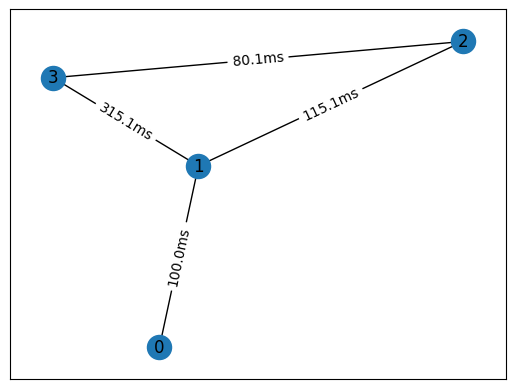

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
for nodes, latency in edge_latency['latency']['mean'].items():
    g.add_edge(nodes[0], nodes[1], weight=latency)
layout = nx.spring_layout(g)
nx.draw_networkx_nodes(g, layout)
nx.draw_networkx_edges(g, layout)
nx.draw_networkx_labels(g, layout)
edge_labels = nx.get_edge_attributes(g, "weight")
edge_labels = {key: str(round(edge_labels[key], 1))+'ms' for key in edge_labels}
nx.draw_networkx_edge_labels(g, layout, edge_labels)
plt.show()

This is cool! We've recreated our network topology without knowing it beforehand.

The really cool thing would be if we could detect issues and do something about them, though. First, we find all the origins and terminations of our messages alongside the average time a message takes to travel that path.

In [17]:
import pandas as pd

df_grouped = df.groupby('message_id', as_index=False)
message_paths = pd.concat([
    df_grouped.head(1)['from_node'].reset_index(drop=True), 
    df_grouped.tail(1)['to_node'].reset_index(drop=True), 
    df_grouped.sum()['latency']
], axis=1).groupby(['from_node', 'to_node']).mean()
message_paths

latency
from_node to_node            
0         1        100.085392
          2        215.172520
          3        414.674665
1         0         99.986161
          2        114.954757
          3        315.473295
2         0        215.211734
          1        115.035190
          3         80.102610
3         0        415.225093
          1        314.905934
          2         80.085288

This looks a lot like our data above, but critically it instead describes the mean latency of a message that goes from any node to any other node, whereas in the queries above it describes only the mean latency of one jump from a node to its neighbour. Notice that this data includes paths that can't be traversed in one jump like from Node 0 to Node 3.

Let's now implement a shortest path algorithm which ignores the number of jumps a message takes and instead optimises *latency* and predict how much of an improvement we'll make. We'll quickly turn our existing edge latency dataframe into something that's a bit friendlier to iterate through:

In [18]:
edge_latency_dict = {}
for key in edge_latency.index.values:
    from_key = key[0]
    to_key = key[1]
    if from_key not in edge_latency_dict:
        edge_latency_dict[from_key] = {}
    edge_latency_dict[from_key][to_key] = edge_latency.loc[from_key].loc[to_key]['latency']['mean']

edge_latency_dict

{0: {1: 99.99040019784478},
 1: {0: 100.03428194905777, 2: 115.06053632007429, 3: 315.1312135510193},
 2: {1: 115.06916648804751, 3: 80.10260960028641},
 3: {1: 315.06064325097555, 2: 80.0852878906088}}

Then we write a simple brute-force search:

In [19]:
def shortest_route(start, end, edge_latency_dict):
    queue = [{'new_path': [start], 'predicted_latency': 0}]
    best = None
    while len(queue) > 0:
        current = queue.pop()
        latest_node = current['new_path'][-1]
        for next_node in edge_latency_dict[latest_node]:
            if next_node in current['new_path']:
                continue
            next_latency = current['predicted_latency'] + edge_latency_dict[latest_node][next_node]
            if next_node == end:
                if best is None or next_latency < best[1]:
                    best = (current['new_path'] + [next_node], next_latency)
            else:
                queue.append({'new_path': [_ for _ in current['new_path']] + [next_node], 'predicted_latency': next_latency})
    return best

message_paths[['new_path', 'predicted_latency']] = message_paths.apply(lambda x: shortest_route(*x.name, edge_latency_dict), axis='columns', result_type='expand')
message_paths

latency      new_path  predicted_latency
from_node to_node                                             
0         1        100.085392        [0, 1]          99.990400
          2        215.172520     [0, 1, 2]         215.050937
          3        414.674665  [0, 1, 2, 3]         295.153546
1         0         99.986161        [1, 0]         100.034282
          2        114.954757        [1, 2]         115.060536
          3        315.473295     [1, 2, 3]         195.163146
2         0        215.211734     [2, 1, 0]         215.103448
          1        115.035190        [2, 1]         115.069166
          3         80.102610        [2, 3]          80.102610
3         0        415.225093  [3, 2, 1, 0]         295.188736
          1        314.905934     [3, 2, 1]         195.154454
          2         80.085288        [3, 2]          80.085288

We do a little analysis to find bad paths

In [20]:
tolerance = 0.05
bad_paths = message_paths
bad_paths['delta_raw'] = bad_paths['latency'] - bad_paths['predicted_latency']
bad_paths['delta_pct'] = bad_paths['delta_raw'] / bad_paths['latency']
bad_paths

latency      new_path  predicted_latency   delta_raw  \
from_node to_node                                                            
0         1        100.085392        [0, 1]          99.990400    0.094991   
          2        215.172520     [0, 1, 2]         215.050937    0.121584   
          3        414.674665  [0, 1, 2, 3]         295.153546  119.521118   
1         0         99.986161        [1, 0]         100.034282   -0.048121   
          2        114.954757        [1, 2]         115.060536   -0.105779   
          3        315.473295     [1, 2, 3]         195.163146  120.310149   
2         0        215.211734     [2, 1, 0]         215.103448    0.108286   
          1        115.035190        [2, 1]         115.069166   -0.033977   
          3         80.102610        [2, 3]          80.102610    0.000000   
3         0        415.225093  [3, 2, 1, 0]         295.188736  120.036356   
          1        314.905934     [3, 2, 1]         195.154454  119.751480   
          2         80.085288        [3, 2]          80.085288    0.000000   

                   delta_pct  
from_node to_node             
0         1         0.000949  
          2         0.000565  
          3         0.288229  
1         0        -0.000481  
          2        -0.000920  
          3         0.381364  
2         0         0.000503  
          1        -0.000295  
          3         0.000000  
3         0         0.289087  
          1         0.380277  
          2         0.000000

In [21]:
bad_paths = bad_paths[bad_paths['delta_pct'] > tolerance]
bad_paths

latency      new_path  predicted_latency   delta_raw  \
from_node to_node                                                            
0         3        414.674665  [0, 1, 2, 3]         295.153546  119.521118   
1         3        315.473295     [1, 2, 3]         195.163146  120.310149   
3         0        415.225093  [3, 2, 1, 0]         295.188736  120.036356   
          1        314.905934     [3, 2, 1]         195.154454  119.751480   

                   delta_pct  
from_node to_node             
0         3         0.288229  
1         3         0.381364  
3         0         0.289087  
          1         0.380277

In [22]:
def report_bad_path(row):
    print(f'''
    The current route from {row.name[0]} to {row.name[1]} takes an average of {round(row['latency'], 1)}ms.
    If we instead rerouted traffic along the following path:
    {row['new_path']}
    it would instead take {round(row['predicted_latency'], 1)}ms, an improvement of {round(row['delta_pct']*100, 1)}%.
    ''')
    
bad_paths.apply(report_bad_path, axis='columns')


    The current route from 0 to 3 takes an average of 414.7ms.
    If we instead rerouted traffic along the following path:
    [0, 1, 2, 3]
    it would instead take 295.2ms, an improvement of 28.8%.
    

    The current route from 1 to 3 takes an average of 315.5ms.
    If we instead rerouted traffic along the following path:
    [1, 2, 3]
    it would instead take 195.2ms, an improvement of 38.1%.
    

    The current route from 3 to 0 takes an average of 415.2ms.
    If we instead rerouted traffic along the following path:
    [3, 2, 1, 0]
    it would instead take 295.2ms, an improvement of 28.9%.
    

    The current route from 3 to 1 takes an average of 314.9ms.
    If we instead rerouted traffic along the following path:
    [3, 2, 1]
    it would instead take 195.2ms, an improvement of 38.0%.
    


from_node  to_node
0          3          None
1          3          None
3          0          None
           1          None
dtype: object

# :)
And finally, we send that info printed info to our stakeholders to make decisions